<a href="https://colab.research.google.com/github/idrisr/colab-notebooks/blob/main/Copy_of_06_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Run once per session
!pip install fastai -q --upgrade

In [3]:
import pandas

# Object Detection

Finding the localized area in which an object presides from two points, the bottom left and top right

![](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/06/maxresdefault.jpg)

In [4]:
from fastai.vision.all import *
from PIL import Image
from PIL.ImageDraw import ImageDraw
from IPython import display

In [5]:
path = untar_data(URLs.PASCAL_2007)

Now how do we get our labels? `fastai` has a `get_annotations` function that we can use to grab the image and their bounding box. The one-line documentation states:
"Open a COCO style json in `fname` and returns the list of filenames (with mabye `prefix`) and labelled bounding boxes."

In [6]:
path.ls()

(#10) [Path('/home/idris/.fastai/data/pascal_2007/test'),Path('/home/idris/.fastai/data/pascal_2007/test_pretty.json'),Path('/home/idris/.fastai/data/pascal_2007/test.json'),Path('/home/idris/.fastai/data/pascal_2007/valid.json'),Path('/home/idris/.fastai/data/pascal_2007/train'),Path('/home/idris/.fastai/data/pascal_2007/test_format.json'),Path('/home/idris/.fastai/data/pascal_2007/train.json'),Path('/home/idris/.fastai/data/pascal_2007/segmentation'),Path('/home/idris/.fastai/data/pascal_2007/train.csv'),Path('/home/idris/.fastai/data/pascal_2007/test.csv')]

We'll want to read out of the `train.json`

In [7]:
path

Path('/home/idris/.fastai/data/pascal_2007')

In [8]:
train = json.load((path/"train.json").open())

In [9]:
IMAGES, TYPE, ANNOTATIONS, CATEGORIES = ['images', 'type', 'annotations', 'cateogries']

In [10]:
train[ANNOTATIONS][1]['segmentation']

[[184, 61, 184, 199, 279, 199, 279, 61]]

In [13]:
imgs, lbl_bbox = get_annotations(path/'train.json')

In [14]:
lbl_bbox[0]

([[155, 96, 351, 270]], ['car'])

Next, we want to be able to quickly look up a corresponding image to it's label. We'll use a dictionary

In [15]:
img2bbox = dict(zip(imgs, lbl_bbox))

In [16]:
img2bbox['000017.jpg'][:-1][0]

[[184, 61, 279, 199], [89, 77, 403, 336]]

In [17]:
TRAIN = Path('/home/idris/.fastai/data/pascal_2007/train')

Let's check the first item

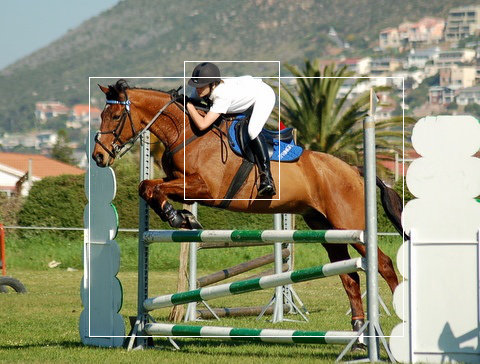

In [118]:
img = Image.open(TRAIN/'000017.jpg')
for box in img2bbox['000017.jpg'][:-1][0]:
    ImageDraw(img).rectangle(tuple(box))
img

In [119]:
first = {k: img2bbox[k] for k in list(img2bbox)[:1]}; first

{'000012.jpg': ([[155, 96, 351, 270]], ['car'])}

Great! Now let's build our `DataBlock`. We'll have two outputs, the bounding box itself and a label, with one input.

In [19]:
getters = [lambda o: path/'train'/o, 
           lambda o: img2bbox[o][0], 
           lambda o: img2bbox[o][1]]

For our transforms, we'll use some of the ones we defined earlier

In [20]:
imagenet_stats

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [121]:
item_tfms = [Resize(128, method='pad'),]
batch_tfms = [Rotate(), Flip(), Dihedral(), Normalize.from_stats(*imagenet_stats)]

Why do we need a custom `get_images`? Because we want our **images** that came back to us, not the entire folder

In [122]:
def get_train_imgs(noop):  return imgs

We'll now make our `DataBlock`. We want to adjust `n_inp` as we expect two outputs

In [123]:
pascal = DataBlock(blocks=(ImageBlock, BBoxBlock, BBoxLblBlock),
                 splitter=RandomSplitter(),
                 get_items=get_train_imgs,
                 getters=getters,
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms,
                 n_inp=1)

In [124]:
dls = pascal.dataloaders(path/'train')

In [125]:
dls.c = 20

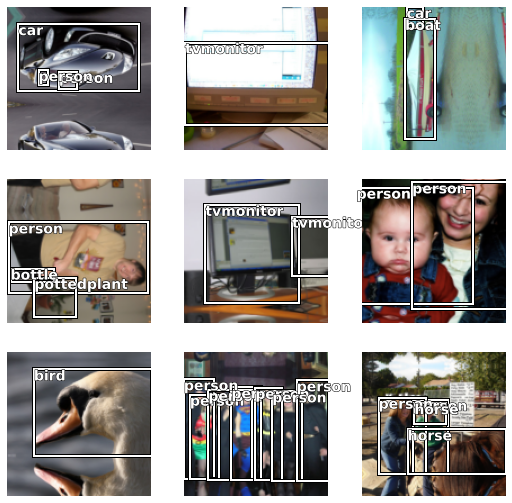

In [126]:
dls.show_batch()

# The Model

The architecture we are going to use is called `RetinaNet`. I've exported this all myself for you guys to use quickly, if you want to explore what's going on in the code I'd recommend the Object Detection lesson [here](https://www.youtube.com/watch?v=Z0ssNAbe81M&t=4496s)

Let's clone my repo and work out of it

In [128]:
!git clone https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0.git
%cd "Practical-Deep-Learning-for-Coders-2.0/Computer Vision"

Cloning into 'Practical-Deep-Learning-for-Coders-2.0'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 1292 (delta 18), reused 27 (delta 6), pack-reused 1227
Receiving objects: 100% (1292/1292), 86.33 MiB | 6.60 MiB/s, done.
Resolving deltas: 100% (805/805), done.
/home/idris/2050-chess-vision/training-data-app/nbs/Practical-Deep-Learning-for-Coders-2.0/Computer Vision/Practical-Deep-Learning-for-Coders-2.0/Computer Vision


In [129]:
from imports import *

We're still going to use transfer learning here by creating an `encoder` (body) of our model and a head

In [ ]:
encoder = create_body(resnet34, pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


Now that we have our encoder, we can call the `RetinaNet` architecture. We'll pass in the encoder, the number of classes, and what we want our final bias to be on the last convolutional layer (how we initialize our model). Jeremy has his example at -4 so let's use this

In [ ]:
get_c(dls)

20

In [ ]:
arch = RetinaNet(encoder, get_c(dls), final_bias=-4)

Another big difference is the head of our model. Instead of our linear layers with pooling layers:

In [ ]:
create_head(124, 4)

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(124, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=124, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=4, bias=False)
)

We have one with a smoother, a classifer, and a `box_regressor` (to get our points)

In [ ]:
arch.smoothers

ModuleList(
  (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [ ]:
arch.classifier

Sequential(
  (0): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (3): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(256, 180, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [ ]:
arch.box_regressor

Sequential(
  (0): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (3): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(256, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

## Loss Function
Now we can move onto our loss function. For RetinaNet to work, we need to define what the aspect ratio's and scales of our image should be. The paper used [1,2**(1/3), 2**(2/3)], but they also used an image size of 600 pixels, so even the largest feature map (box) gave anchors that covered less than the image. But for us it would go over. As such we will use -1/3 and -2/3 instead. We will need these for inference later!

In [ ]:
ratios = [1/2,1,2]
scales = [1,2**(-1/3), 2**(-2/3)]

Let's make our loss function, which is `RetinaNetFocalLoss`

In [ ]:
crit = RetinaNetFocalLoss(scales=scales, ratios=ratios)

Now let's make our `Learner`!

We want to freeze our `encoder` and keep everything else unfrozen to start

In [ ]:
def _retinanet_split(m): return L(m.encoder,nn.Sequential(m.c5top6, m.p6top7, m.merges, m.smoothers, m.classifier, m.box_regressor)).map(params)

In [ ]:
learn = Learner(dls, arch, loss_func=crit, splitter=_retinanet_split)

In [ ]:
learn.freeze()

Now let's train!

In [ ]:
learn.fit_one_cycle(10, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,time
0,3.256616,2.996806,00:30
1,2.862086,2.687984,00:28
2,2.666158,2.688018,00:29
3,2.561396,2.667681,00:28
4,2.478174,2.413936,00:28
5,2.423190,2.493899,00:28
6,2.339488,2.480800,00:28
7,2.278033,2.479896,00:28
8,2.239934,2.422191,00:28
9,2.204041,2.403617,00:29
